In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, LSTM
from tensorflow.keras.layers import RepeatVector, Bidirectional, TimeDistributed
from tensorflow.keras.layers import multiply, concatenate, Reshape, BatchNormalization

from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Parameters

In [2]:
DATA_LEN = 200
PREAMBLE_LEN = 40
CHANNEL_LEN = 1

SNR_TRAIN = 20.0
OMEGA_TRAIN = 1/50

## Network Funcs

In [3]:
from tensorflow.keras.layers import Lambda
tf.keras.backend.clear_session()

def cfo_network(preamble, preamble_conv, scope="CFOCorrectionNet"):
    """Build CFO Correction Network
    Arguments:
        preamble :     tf.Tensor float32 -  [batch, preamble_length, 2]
        preamble_conv: tf.Tensor float32 -  [batch, preamble_length, 2]
        
    Return:
        cfo_est: tf.Tensor float32 - [batch_size, 1]
    """
    with tf.name_scope(scope):
        inputs = tf.keras.layers.concatenate([preamble, preamble_conv], axis=-1)
        x = Bidirectional(GRU(20, 'selu', return_sequences=True, name=scope+"_bi_gru_1"))(inputs)
        x = Bidirectional(GRU(20, 'selu', return_sequences=False,name=scope+"_bi_gru_2"))(x)
        cfo_est = Dense(1, 'linear', name='CFOEstimate')(x)
    return cfo_est


def equalization_network(cfo_corrected_packets, cfo_corrected_preamble, preamble):
    """Given a [preamble, preambe_conv] and """
    
    with tf.name_scope('PreambleTransform'):
        inputs = tf.keras.layers.concatenate([preamble, cfo_corrected_preamble], axis=-1,
                                            name='Preamble_RotatedPreamble')
        x = Bidirectional(GRU(20, 'selu', return_sequences=True, name="PreambleTransform_bi_gru_1"))(inputs)
        x = Bidirectional(GRU(20, 'selu', return_sequences=False,name="PreambleTransform_bi_gru_2"))(x)
        whatisthis = Dense(2, 'linear', name='TransformPreamble')(x)
        
    whatisthis = RepeatVector(DATA_LEN + PREAMBLE_LEN)(whatisthis)
    inputs = tf.keras.layers.concatenate([cfo_corrected_packets, whatisthis], axis=1)
    with tf.name_scope('EqualizationNet'):
        x = Bidirectional(LSTM(20, return_sequences=True))(inputs)
        x = Bidirectional(LSTM(20, return_sequences=False))(x)
        x = Dense(400, activation='relu')(x)
        
        x = Dense(400, activation='linear')(x)
        equalized_packets = Reshape((200, 2))(x)
    return equalized_packets


def demod_and_ecc_network(equalized_packets):
    num_hidden_layers = 2
    hidden_units= 400
    with tf.name_scope('DemodAndDecodeNet'):
        x = equalized_packets
        for _ in range(num_hidden_layers):
            x = Bidirectional(GRU(hidden_units, return_sequences=True))(x)
            x = BatchNormalization()(x)

    data_estimates = TimeDistributed(Dense(1, activation='sigmoid'), name='DataEstimate')(x)
    
    return data_estimates

def cfo_correction_func(kwargs):
    """Rotate packets given an omega estimate 
    
    Arguments:
        omega_estimate: tf.Tensor float32 - [batch, 1]
        packets:        tf.Tensor float32 - [batch, (preamble_len + data_len), 2] 
        
    Return:
        rotated_packets: tf.Tensor float32 - [batch, (preamble_len + data_len), 2] 
    """ 
    # Because of Lambda Layer, we need to pass arguments as Kwargs
    omega_estimate, packets = kwargs[0], kwargs[1]

    # Build rotation matrix
    with tf.name_scope('rotation_matrix'):
        packet_len      = tf.cast(tf.shape(packets)[1], tf.float32) # preamble_len + data_len
        rotation_matrix = tf.exp(tf.complex(0.0, - 1.0 * omega_estimate * tf.range(packet_len)))

    # CFO Correction 
    with tf.name_scope('cfo_correction'):
        rotated_packets = tf.complex(packets[..., 0], packets[...,1]) * rotation_matrix

    # Encode complex packets into 2D array
    corrected_preambe = tf.stack([tf.real(rotated_packets)[..., :PREAMBLE_LEN], 
                                  tf.imag(rotated_packets)[..., :PREAMBLE_LEN]], 
                                  axis=-1, name='corrected_preamble')
    rotated_packets = tf.stack([tf.real(rotated_packets), 
                                tf.imag(rotated_packets)], 
                               axis=-1, name='rotated_packets')
    return corrected_preambe, rotated_packets

##  Build a  Gigantic Model!

In [4]:
preamble          = Input(shape=(40, 2), name='preamble')
preamble_conv     = Input(shape=(40, 2), name='preamble_conv')
corrupted_packets = Input(shape=(240, 2), name='corrupted_packets')  # [preamble_conv, data_conv]

 
cfo_est = cfo_network(preamble, preamble_conv)
cfo_corrected_preamble, cfo_corrected_packets = \
    Lambda(cfo_correction_func,name='CFO_Correction')(
            [cfo_est, corrupted_packets])

equalized_packets = equalization_network(cfo_corrected_packets, cfo_corrected_preamble, preamble)
data_estimates    = demod_and_ecc_network(equalized_packets)

model = tf.keras.Model([corrupted_packets, preamble, preamble_conv], data_estimates)

print("Number of training parameters: %d" % model.count_params())

Number of training parameters: 4067804


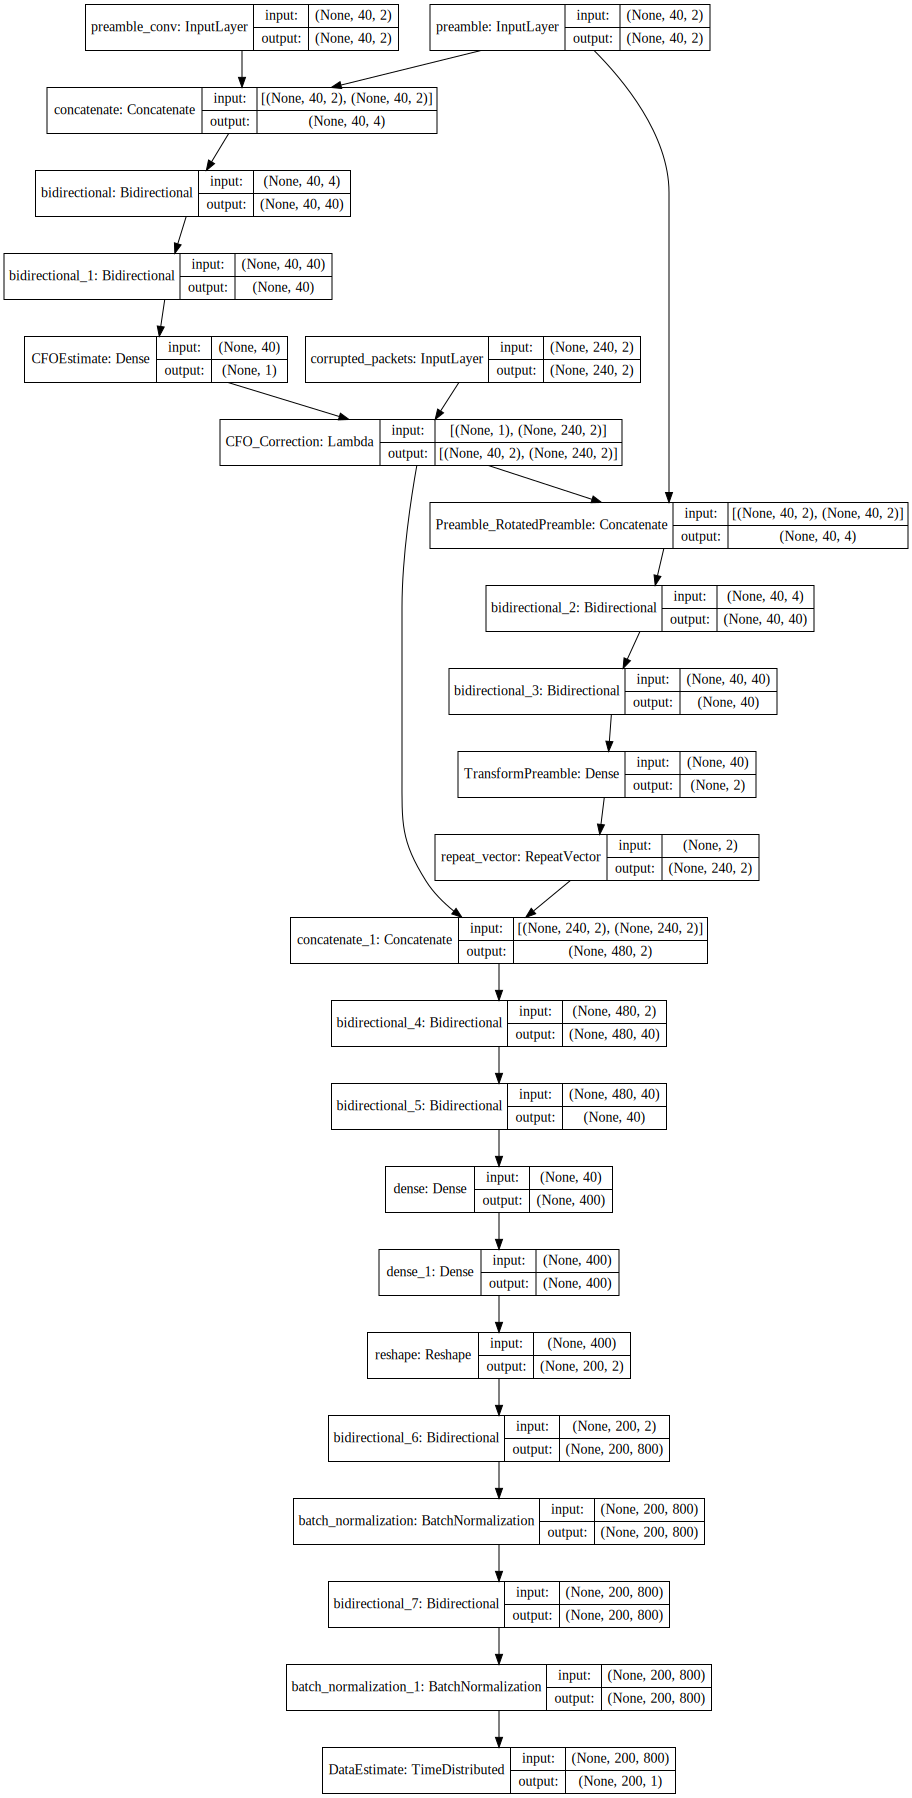

In [5]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [6]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:800px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:820px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [7]:
show_graph(tf.get_default_graph().as_graph_def())

In [8]:
def encode_complex(inputs):
    """TF does not support complex numbers for training. We encode complex inputs into
    2D array."""
    return np.stack([np.real(inputs), np.imag(inputs)], -1)

def radio_data_generator(radio, omega, snr_dB, batch_size, seed=None):
    """Generate [preamble, preamble_conv] data in batch.
    """
    np.random.seed(seed)
    while True:
        batch = [radio.generate_packet(omega, snr_dB) for i in range(batch_size)]
        
        # In order to train CFO Correction Network, we only need access to 
        # omegas, preambles and preambles convolved data.
        packets, omegas, modulated_packets, _, _, corrupted_packets = zip(*batch)
        
        # Ignore preabmle as ground truths
        packets = np.expand_dims(np.array(packets)[:, radio.preamble_len:], -1)

        # Obtain the preamble and preamble conv
        preamble_conv = encode_complex(np.array(corrupted_packets)[:, :radio.preamble_len])
        preamble = encode_complex(np.array(modulated_packets)[:, :radio.preamble_len])
        
        corrupted_packets = encode_complex(np.array(corrupted_packets))
        yield [corrupted_packets, preamble, preamble_conv], packets

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
preamble (InputLayer)           (None, 40, 2)        0                                            
__________________________________________________________________________________________________
preamble_conv (InputLayer)      (None, 40, 2)        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 40, 4)        0           preamble[0][0]                   
                                                                 preamble_conv[0][0]              
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 40, 40)       3000        concatenate[0][0]                
__________

In [9]:
from commpy.modulation import QAMModem
from commpy.channelcoding import Trellis
from radioml.dataset import RadioData

# Define Data generator
radio_data = RadioData(QAMModem(4), 
                       Trellis(np.array([2]), np.array([[0o7, 0o5]])), 
                       data_len=DATA_LEN, 
                       preamble_len=PREAMBLE_LEN, 
                       channels_len=CHANNEL_LEN)

def BLER(y, y_pred):
    num_blocks_per_batch = tf.cast(tf.shape(y)[0], tf.int64)
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.count_nonzero(tf.reduce_sum(hamming_distances, axis=1)) \
            / num_blocks_per_batch

model.compile('adam', 'mse', metrics=[BLER])
# Callbacks to save best model during training
best_model_backup = tf.keras.callbacks.ModelCheckpoint('end2end.hdf5', save_best_only=True)

history = model.fit_generator(
    generator = radio_data_generator(radio_data, OMEGA_TRAIN, SNR_TRAIN, batch_size=128),
    steps_per_epoch=1000,
    validation_data = radio_data_generator(radio_data,OMEGA_TRAIN, SNR_TRAIN, batch_size=128, seed=2018),
    validation_steps=100,
    callbacks=[best_model_backup],
    epochs=20)

Epoch 1/20
 367/1000 [==========>...................] - ETA: 47:00 - loss: 0.2508 - BLER: 1.0000

KeyboardInterrupt: 